In [1]:
#carregando as bibliotecas a serem utilizadas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier

In [2]:
#carregando os valores e limpando os dados
bvsp = pd.read_csv("BVSP Index.csv",parse_dates=['Date'],index_col='Date')

#transformando o valor para float
bvsp['Var.Day(%)']=bvsp['Var.Day(%)'].str.replace(',','.').astype('float')

#remove os valores "de lado", passando para alta ou baixa
bvsp['Class']=np.where(bvsp['Var.Day(%)']>=0,'Alta','Baixa')
bvsp['Class']=bvsp['Class'].astype('category')

print(bvsp.head())
print(bvsp.info())
bvsp_original = bvsp

             Open   High    Low  Close  Adj Close  Var.Day(%)  Class  Volume
Date                                                                        
2000-01-03  17098  17408  16719  16930      16930       -0.98  Baixa       0
2000-01-04  16908  16908  15851  15851      15851       -6.37  Baixa       0
2000-01-05  15871  16302  15350  16245      16245        2.49   Alta       0
2000-01-06  16237  16499  15977  16107      16107       -0.85  Baixa       0
2000-01-07  16125  16449  16125  16309      16309        1.25   Alta       0
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4785 entries, 2000-01-03 to 2019-05-03
Data columns (total 8 columns):
Open          4785 non-null int64
High          4785 non-null int64
Low           4785 non-null int64
Close         4785 non-null int64
Adj Close     4785 non-null int64
Var.Day(%)    4785 non-null float64
Class         4785 non-null category
Volume        4785 non-null int64
dtypes: category(1), float64(1), int64(6)
memory usage: 303.

In [3]:
#transformando valores absolutos em percetuais
bvsp['OpenPct']=bvsp['Open'].pct_change()
bvsp['HighPct']=bvsp['High'].pct_change()
bvsp['LowPct']=bvsp['Low'].pct_change()
bvsp['ClosePct']=bvsp['Close'].pct_change()

bvsp.head()

,Open,High,Low,Close,Adj Close,Var.Day(%),Class,Volume,OpenPct,HighPct,LowPct,ClosePct
Date,,,,,,,,,,,,
2000-01-03,17098,17408,16719,16930,16930,-0.98,Baixa,0,NaN,NaN,NaN,NaN
2000-01-04,16908,16908,15851,15851,15851,-6.37,Baixa,0,-0.011112,-0.028722,-0.051917,-0.063733
2000-01-05,15871,16302,15350,16245,16245,2.49,Alta,0,-0.061332,-0.035841,-0.031607,0.024856
2000-01-06,16237,16499,15977,16107,16107,-0.85,Baixa,0,0.023061,0.012084,0.040847,-0.008495
2000-01-07,16125,16449,16125,16309,16309,1.25,Alta,0,-0.006898,-0.003030,0.009263,0.012541


In [4]:
#tirando os valores desnecessários para a classificação
bvsp = bvsp[['OpenPct','HighPct','LowPct','ClosePct','Class']].dropna()
bvsp.head()

,OpenPct,HighPct,LowPct,ClosePct,Class
Date,,,,,
2000-01-04,-0.011112,-0.028722,-0.051917,-0.063733,Baixa
2000-01-05,-0.061332,-0.035841,-0.031607,0.024856,Alta
2000-01-06,0.023061,0.012084,0.040847,-0.008495,Baixa
2000-01-07,-0.006898,-0.003030,0.009263,0.012541,Alta
2000-01-10,0.012403,0.036963,0.012403,0.043718,Alta


In [5]:
#serão utilizados os valores de Percetual Change (pct_change) dos 7 dias anteriores para gerar a classe
n_dias = 30
bvspData = pd.DataFrame(index=bvsp.index)
for i in range(n_dias):
    shiftedValues = bvsp[['OpenPct','HighPct','LowPct','ClosePct']].shift(periods=i+1).add_suffix('_d-'+str(i+1))
    bvspData = bvspData.join(shiftedValues)
    #print(shiftedValues.head(7))

bvspData = bvspData.join(bvsp['Class']).dropna()
print(bvspData.head(1))
print(bvspData.tail(1))

            OpenPct_d-1  HighPct_d-1  LowPct_d-1  ClosePct_d-1  OpenPct_d-2  \
Date                                                                          
2000-02-16    -0.014655    -0.018178   -0.016623      0.005724    -0.029622   

            HighPct_d-2  LowPct_d-2  ClosePct_d-2  OpenPct_d-3  HighPct_d-3  \
Date                                                                          
2000-02-16    -0.027217   -0.015588     -0.014599     0.014591     0.005516   

            ...  ClosePct_d-28  OpenPct_d-29  HighPct_d-29  LowPct_d-29  \
Date        ...                                                           
2000-02-16  ...      -0.008495     -0.061332     -0.035841    -0.031607   

            ClosePct_d-29  OpenPct_d-30  HighPct_d-30  LowPct_d-30  \
Date                                                                 
2000-02-16       0.024856     -0.011112     -0.028722    -0.051917   

            ClosePct_d-30  Class  
Date                              
2000-02-16      -

In [6]:
#transformando os dados em numpy array
train_data = np.array(bvspData.iloc[:,:-1])
print(train_data.shape)

#mudando a classe para valor numérico
class_data = np.where(bvspData.iloc[:,-1]=='Alta',1,0)
print(class_data.shape)

(4754, 120)
(4754,)


In [7]:
#realizando a classificação usando SVM e Cross Validation com diferentes kernels
kernels = [ 'linear', 'poly', 'rbf', 'sigmoid']
scores={}
for kernelName in kernels:
    clf = svm.SVC(kernel=kernelName,gamma='scale')
    score = cross_val_score(clf, train_data, class_data, cv=5)
    print('Score mínimo para '+kernelName+": "+str(np.min(score)))
    scores[kernelName]=score
print(scores)

Score mínimo para linear: 0.519453207150368
Score mínimo para poly: 0.49842271293375395
Score mínimo para rbf: 0.501577287066246
Score mínimo para sigmoid: 0.48580441640378547
{'linear': array([0.51945321, 0.51945321, 0.51945321, 0.51945321, 0.52      ]), 'poly': array([0.50683491, 0.51735016, 0.50262881, 0.49842271, 0.53368421]), 'rbf': array([0.51945321, 0.50683491, 0.51735016, 0.50157729, 0.51473684]), 'sigmoid': array([0.49842271, 0.48580442, 0.50473186, 0.52681388, 0.52      ])}


In [8]:
#realizando a classificação usando RandomForest
clf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
score = cross_val_score(clf, train_data, class_data, cv = 5)
print(score)

[0.51524711 0.52471083 0.51629863 0.51735016 0.52947368]


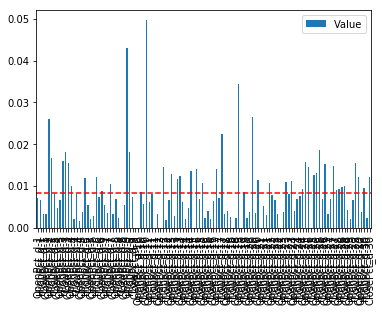

Features com valor acima do threshold:
Index(['OpenPct_d-2', 'HighPct_d-2', 'HighPct_d-3', 'LowPct_d-3',
       'ClosePct_d-3', 'OpenPct_d-4', 'HighPct_d-5', 'HighPct_d-6',
       'ClosePct_d-6', 'LowPct_d-7', 'OpenPct_d-9', 'HighPct_d-9',
       'HighPct_d-10', 'ClosePct_d-10', 'HighPct_d-12', 'OpenPct_d-13',
       'LowPct_d-13', 'ClosePct_d-13', 'ClosePct_d-14', 'HighPct_d-15',
       'ClosePct_d-15', 'OpenPct_d-17', 'LowPct_d-17', 'OpenPct_d-19',
       'LowPct_d-19', 'HighPct_d-20', 'ClosePct_d-20', 'ClosePct_d-21',
       'HighPct_d-23', 'ClosePct_d-23', 'ClosePct_d-24', 'OpenPct_d-25',
       'HighPct_d-25', 'ClosePct_d-25', 'OpenPct_d-26', 'HighPct_d-26',
       'ClosePct_d-26', 'LowPct_d-27', 'ClosePct_d-27', 'OpenPct_d-28',
       'HighPct_d-28', 'LowPct_d-28', 'LowPct_d-29', 'ClosePct_d-29',
       'HighPct_d-30', 'ClosePct_d-30'],
      dtype='object')


In [9]:
#analisando a importância dos parâmetros
clf.fit(train_data,class_data)
featureImportance = pd.DataFrame(index=bvspData.iloc[:,:-1].columns)
featureImportance['Value'] = 0

#colocando os valores em um dataframe para poder plotar
i = 0
for value in clf.feature_importances_:
    featureImportance.iloc[i,0]=value
    i+=1

#plotando o dataframe
ax = featureImportance.plot(kind='bar')
ax.axhline(y=np.mean(featureImportance['Value']),color='r',linestyle='--')
plt.show()
print('Features com valor acima do threshold:')
important = featureImportance[featureImportance['Value']>=np.mean(featureImportance['Value'])].index
print(important)

In [10]:
#usando informações das features importantes
bvspImportant = bvspData[important]
print(bvspImportant.head())

#transformando os dados em numpy array
train_data = np.array(bvspImportant.iloc[:,:-1])
print(train_data.shape)

#mudando a classe para valor numérico
class_data = np.where(bvspData.iloc[:,-1]=='Alta',1,0)
print(class_data)

            OpenPct_d-2  HighPct_d-2  HighPct_d-3  LowPct_d-3  ClosePct_d-3  \
Date                                                                          
2000-02-16    -0.029622    -0.027217     0.005516   -0.007050     -0.028005   
2000-02-17    -0.014655    -0.018178    -0.027217   -0.015588     -0.014599   
2000-02-18     0.005781     0.017566    -0.018178   -0.016623      0.005724   
2000-02-21     0.010881     0.002740     0.017566    0.016733      0.010658   
2000-02-22    -0.007562    -0.015795     0.002740    0.013301     -0.007343   

            OpenPct_d-4  HighPct_d-5  HighPct_d-6  ClosePct_d-6  LowPct_d-7  \
Date                                                                          
2000-02-16    -0.020897     0.008383     0.033267      0.030895    0.015740   
2000-02-17     0.014591    -0.011331     0.008383     -0.017393    0.028344   
2000-02-18    -0.029622     0.005516    -0.011331      0.013235   -0.001370   
2000-02-21    -0.014655    -0.027217     0.005516  

In [11]:
#realizando a classificação usando SVM e Cross Validation com diferentes kernels
kernels = [ 'linear', 'poly', 'rbf', 'sigmoid']
scores={}
for kernelName in kernels:
    clf = svm.SVC(kernel=kernelName,gamma='scale')
    score = cross_val_score(clf, train_data, class_data, cv=5)
    print('Score médio para '+kernelName+": "+str(np.mean(score)))
    scores[kernelName]=score
print(scores)

#realizando a classificação usando RandomForest
clf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
score = cross_val_score(clf, train_data, class_data, cv = 5)
print(np.mean(score))

Score médio para linear: 0.5195625657202945
Score médio para poly: 0.5164099839504124
Score médio para rbf: 0.5265066135369971
Score médio para sigmoid: 0.4915880236869777
{'linear': array([0.51945321, 0.51945321, 0.51945321, 0.51945321, 0.52      ]), 'poly': array([0.52260778, 0.52681388, 0.50262881, 0.50052576, 0.52947368]), 'rbf': array([0.50893796, 0.53522608, 0.52891693, 0.52050473, 0.53894737]), 'sigmoid': array([0.47739222, 0.52681388, 0.47739222, 0.47528917, 0.50105263])}
0.5216676075045659


In [12]:
#pca
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

x = StandardScaler().fit_transform(bvspData.iloc[:,:-1])

pca = PCA(n_components=2)
principalComponents = pd.DataFrame(pca.fit_transform(x))

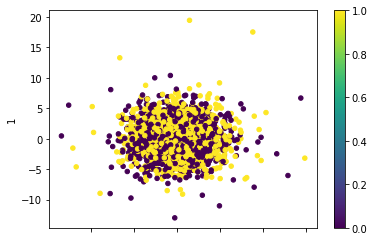

In [13]:
principalComponents.plot(kind='scatter',x=0,y=1,c=class_data,cmap='viridis')
plt.show()

In [32]:
Df = pd.DataFrame(bvsp_original)[bvspData.index[0]:]

clf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
clf.fit(train_data,class_data)

Df['Predicted_Signal_rf'] = clf.predict(train_data)
Df['Predicted_Signal_rf'] = Df['Predicted_Signal_rf'].shift(-1)

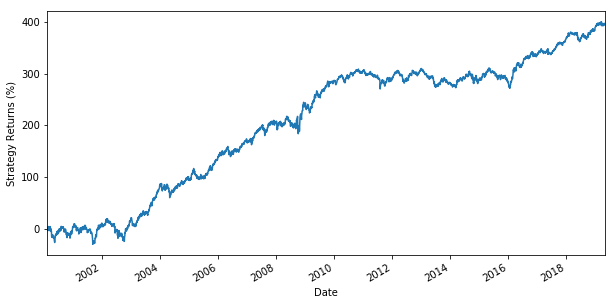

In [34]:
# calculando o retorno usando o algoritmo
# retirado de https://www.quora.com/Can-time-series-analysis-be-used-to-predict-stock-trends/answer/Ishan-Shah-150
Df['Return'] = np.log(Df.Close.shift(-1) / Df.Close)*100
Df['Strategy_Return_rf'] = Df.Return * Df.Predicted_Signal_rf
Df['Strategy_Return_rf'].cumsum().plot(figsize=(10,5))
plt.ylabel("Strategy Returns (%)")
plt.show()

In [55]:
#usando xgboost
import xgboost as xgb
from sklearn.model_selection import train_test_split

data_dmatrix = xgb.DMatrix(data=train_data,label=class_data)

xg_reg = xgb.XGBClassifier()

X_train, X_test, y_train, y_test = train_test_split(train_data, class_data, test_size=0.4)
xg_reg.fit(X_train,y_train)

#cross_val
n_folds = 5
early_stopping = 10
params = {'eta': 0.02, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.7, 'objective': 'binary:logistic', 'seed': 99, 'silent': 1, 'eval_metric':'auc', 'nthread':4}

cv = xgb.cv(params, data_dmatrix, 5000, nfold=n_folds, early_stopping_rounds=early_stopping, verbose_eval=1)
print(cv)

preds = xg_reg.predict(train_data)
Df['Predicted_Signal_xg'] = preds
Df['Predicted_Signal_xg'] = Df['Predicted_Signal_xg'].shift(-1)

print('Acurácia = ' + str(np.sum(preds==np.where(Df['Class']=='Alta',1,0))/len(Df.index)))

[0]	train-auc:0.599098+0.015243	test-auc:0.483692+0.0114324
[1]	train-auc:0.643068+0.0172096	test-auc:0.491699+0.00961072
[2]	train-auc:0.672993+0.0166397	test-auc:0.489602+0.00838368
[3]	train-auc:0.69423+0.0130469	test-auc:0.498113+0.0109268
[4]	train-auc:0.712045+0.0107338	test-auc:0.501305+0.00920721
[5]	train-auc:0.72296+0.0141642	test-auc:0.505942+0.00851785
[6]	train-auc:0.736214+0.00850633	test-auc:0.509299+0.00765419
[7]	train-auc:0.743733+0.0107347	test-auc:0.509669+0.0062615
[8]	train-auc:0.749774+0.00911905	test-auc:0.509675+0.00717495
[9]	train-auc:0.760157+0.00812633	test-auc:0.513297+0.00590921
[10]	train-auc:0.767692+0.0094299	test-auc:0.51338+0.00786137
[11]	train-auc:0.774045+0.009846	test-auc:0.514941+0.00835999
[12]	train-auc:0.778127+0.0117979	test-auc:0.513882+0.00864592
[13]	train-auc:0.783459+0.012184	test-auc:0.511723+0.00776749
[14]	train-auc:0.789601+0.0104697	test-auc:0.511959+0.00708781
[15]	train-auc:0.793684+0.00970945	test-auc:0.511974+0.00824189
[16]	tr

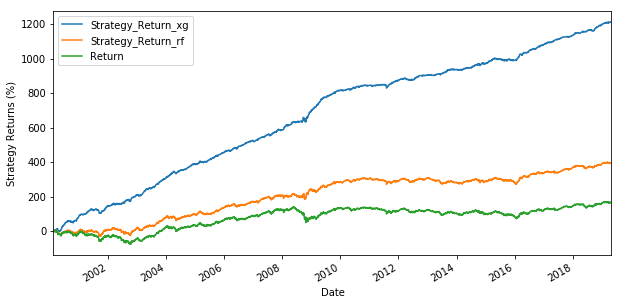

In [56]:
# calculando o retorno usando o algoritmo
# retirado de https://www.quora.com/Can-time-series-analysis-be-used-to-predict-stock-trends/answer/Ishan-Shah-150
Df['Return'] = np.log(Df.Close.shift(-1) / Df.Close)*100
Df['Strategy_Return_xg'] = Df.Return * Df.Predicted_Signal_xg
Df['Correct_Return'] = Df.Return * np.where(Df['Class'].shift(-1)=='Alta',1,0)
Df[['Strategy_Return_xg','Strategy_Return_rf','Return']].cumsum().plot(figsize=(10,5))
plt.ylabel("Strategy Returns (%)")
plt.show()

In [57]:
print(Df[['Predicted_Signal_xg','Class']])

            Predicted_Signal_xg  Class
Date                                  
2000-02-16                  0.0   Alta
2000-02-17                  0.0  Baixa
2000-02-18                  1.0  Baixa
2000-02-21                  0.0   Alta
2000-02-22                  1.0  Baixa
2000-02-23                  0.0   Alta
2000-02-24                  1.0  Baixa
2000-02-25                  0.0   Alta
2000-02-28                  0.0  Baixa
2000-02-29                  1.0   Alta
2000-03-01                  1.0   Alta
2000-03-02                  1.0   Alta
2000-03-03                  1.0   Alta
2000-03-08                  1.0  Baixa
2000-03-09                  1.0   Alta
2000-03-10                  1.0  Baixa
2000-03-13                  0.0  Baixa
2000-03-14                  1.0  Baixa
2000-03-15                  1.0   Alta
2000-03-16                  1.0   Alta
2000-03-17                  1.0  Baixa
2000-03-20                  1.0   Alta
2000-03-21                  0.0   Alta
2000-03-22               